In [1]:
import sys
sys.path.append("/home/huaqingj/MyResearch/TVDN")

In [2]:
from pyTVDN import TVDNDetect, TVDNRankTuning
from pathlib import Path
from scipy.io import loadmat
from scipy.signal import detrend
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyTVDN.tmpUtils import *
from scipy.signal import lfilter, firls, decimate
%matplotlib inline
plt.style.use('ggplot')

In [90]:
from pprint import pprint
import pickle
from easydict import EasyDict as edict
import warnings
from pyTVDN.TVDNutils import *
from pyTVDN.utils import in_notebook
if in_notebook():
    from tqdm import tqdm_notebook as tqdm
else:
    from tqdm import tqdm

class TVDNDetect1(TVDNDetect):
    def __init__(self, Ymat, ReconXmat=ReconXmatNewBspStep, numStep=1, smoothType="Bspline", dataType=None, 
                 saveDir=None, showProgress=True, **paras):
        """
        Input:
            Ymat: The data matrix, d x n
            dataType: real data type, fMRI or MEG
            saveDir: Dir to save the results, if not specified, not save
            paras: Other parameters. There are default valuesi but you may specify these parameters manually.
               Inlcuding:
                    kappa: The parameter of penalty in MBIC
                    Lmin: The minimal length between 2 change points
                    r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
                    MaxM: int, maximal number of change point 
                    lamb: The smooth parameter for B-spline
                    downRate: The downsample factor, determine how many Ai matrix to contribute to estimate the eigen values/vectors.
                    decimateRate: Mainly for MEG data. The rate to decimate from MEG data.
                    T: The time course
                    is_detrend: Whether detrend data or not
                    fct: The factor to adjust h when estimating A matrix
                    fName:  The file name when saving the results
                    freq: The parameter used drawing the eigen values plots
        """
        self.Ymat = Ymat
        self.paras = edict()
        if dataType is not None:
            self.dataType = dataType.lower()
        else:
            self.dataType = dataType

        if smoothType is not None:
            self.smoothType = smoothType.lower()
        else:
            self.smoothType = smoothType


        if self.dataType == "meg":
            self.paras.kappa = 2.65
            self.paras.Lmin = 60
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-4
            self.paras.downRate = 20
            self.paras.decimateRate = 10
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "MEG"
            self.paras.freq = 60
            self.paras.nbasis = 10
        elif self.dataType == "fmri":
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 10
            self.paras.lamb = 1e-4
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 0.5
            self.paras.fName = "fMRI"
            self.paras.freq = 0.5
            self.paras.nbasis = 10
        else:
            self.paras.kappa = 2.65
            self.paras.Lmin = 4
            self.paras.r = 6
            self.paras.MaxM = 19
            self.paras.lamb = 1e-6
            self.paras.downRate = 4
            self.paras.decimateRate = None
            self.paras.T = 2
            self.paras.is_detrend = False
            self.paras.fct = 1
            self.paras.fName = "simu"
            self.paras.freq = 180
            self.paras.nbasis = 10
        keys = list(self.paras.keys())
        for key in paras.keys():
            self.paras[key] = paras[key]
        if showProgress:
            print("The parameters for detection are:")
            pprint(self.paras)
        
        if saveDir is not None:
            self.saveDir = Path(saveDir)
            if not self.saveDir.exists():
                self.saveDir.mkdir()
        else:
            self.saveDir = saveDir
            
        self.numStep = numStep
        self.ReconXmat = ReconXmat
        self.showProgress = showProgress
        self.nYmat = None
        self.Xmat = None
        self.dXmat = None
        self.time = None
        self.midRes = None
        self.nXmat = None
        self.ndXmat = None
        self.Amat = None
        self.finalRes = None
        self.RecYmatAll = None
        self.RecResCur = None
        self.numchgs = None
        self.ecpts = None
        self.canpts = None
    
    
    def SmoothEst(self):
        if self.nYmat is None:
            self._Preprocess()
        d, n = self.nYmat.shape
        acTime = n / self.paras.freq
        self.ptime = np.linspace(0, acTime, n)
        self.time = np.linspace(0, self.paras.T, n)
        divNum = 100
        if self.smoothType == "bspline":
            self.dXmat = np.zeros((d, n))
            self.Xmat = np.zeros((d, n))
            if n%divNum == 0:
                numLoop = int(n/divNum)
            else:
                numLoop = int(n/divNum) + 1
            for i in range(numLoop):
                if (i+1)*divNum <= n:
                    low = i*divNum
                    up = (i+1)*divNum
                else:
                    low = i*divNum
                    up = n
                self.dXmat[:, low:up], self.Xmat[:, low:up] = GetBsplineEst(self.nYmat[:, low:up], self.time[low:up], 
                                                                            lamb=self.paras.lamb)
        elif self.smoothType == "fourier":
            self.dXmat, self.Xmat = GetFourierEst(self.nYmat, self.time, nbasis=self.paras.nbasis)
            
    def GetRecResCur(self):
        numchg = len(self.ecpts)
        if self.RecYmatAll is not None:
            self.RecResCur = self.RecYmatAll[numchg]
        elif self.saveDir is not None:
            RecYmatAllPath = self.saveDir/f"{self.paras.fName}_Rank{self.paras.r}_RecAll.pkl"
            if RecYmatAllPath.exists():
                with open(RecYmatAllPath, "rb") as f:
                    self.RecYmatAll = pickle.load(f)
                self.RecResCur = self.RecYmatAll[numchg]
            else:
                MaxM = self.paras.MaxM
                r = self.paras.r
                finalRes = self.finalRes
                midRes = self.midRes
                _, n = midRes.nXmat.shape
                time = np.linspace(0, self.paras.T, n)
                tStep = np.diff(time)[0]
                ndXmat = midRes.ndXmat
                nXmat = midRes.nXmat
                kpidxs = midRes.kpidxs
                eigVecs = midRes.eigVecs
                self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, 
                                                tStep, r=r, numStep=self.numStep, is_full=True) 
        else:
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            self.RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, 
                                            tStep, r=r, numStep=self.numStep, is_full=True) 
    
    def GetRecYmats(self):
        if self.RecYmatAll is None:
            RecYmatAll = []
            MaxM = self.paras.MaxM
            r = self.paras.r
            finalRes = self.finalRes
            midRes = self.midRes
            _, n = midRes.nXmat.shape
            time = np.linspace(0, self.paras.T, n)
            tStep = np.diff(time)[0]
            ndXmat = midRes.ndXmat
            nXmat = midRes.nXmat
            kpidxs = midRes.kpidxs
            eigVecs = midRes.eigVecs
            if self.showProgress:
                pbar = tqdm(range(MaxM+1))
                for numchg in pbar:
                    pbar.set_description(f"Kappa Tuning")
        #            print(f"Current number of change point is {numchg}.")
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r,
                                                   numStep=self.numStep, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r, 
                                                   numStep=self.numStep, is_full=True) 
                    RecYmatAll.append(RecResCur)
            else:
                for numchg in range(MaxM+1):
                    if numchg == 0:
                        RecResCur = self.ReconXmat([], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat, tStep, r=r, numStep=self.numStep, is_full=True) 
                    else:
                        RecResCur = self.ReconXmat(finalRes.chgMat[numchg-1, :numchg], ndXmat, nXmat, kpidxs, eigVecs, self.Xmat,
                                                   tStep, r=r, numStep=self.numStep, is_full=True) 
                    RecYmatAll.append(RecResCur)
            self.RecYmatAll = RecYmatAll

In [91]:
def ReconXmatNewBspStep(ecpts, ndXmat, nXmat, kpidxs, eigVecs, Ymat, tStep, r, numStep=30, is_full=False):
    """
    Input: 
        ecpts: Estimated change points, 
        ndXmat: a rAct x n matrix
        nXmat: a rAct x n matrix
        kpidxs: The intermedian output when calculating ndXmat, nXmat
        eigVecs: The matrix of eigen vectors of A matrix, d x d
        Ymat: The matrix to construct, d x n 
        tStep: The time step
        r: The rank setted beforehand, in most cases, r=rAct. If we have non-complex singular values, r < rAct
        if_full: Where outputing full info or not

    Return:
        Estimated Xmat, d x n
    """
    print(f"The class calls the new reconstruction function, ReconXmatNewBspStep")
    rAct, n = ndXmat.shape
    d, _ = Ymat.shape
    ecptsfull = np.concatenate(([0], ecpts, [n])) - 1
    ecptsfull = ecptsfull.astype(np.int)
    numchgfull = len(ecptsfull)

    ResegS = np.zeros((numchgfull-1, r), dtype=np.complex)
    for  itr in range(numchgfull-1):
        lower = ecptsfull[itr] + 1
        upper = ecptsfull[itr+1] + 1
        Ycur = ndXmat[:, lower:upper]
        Xcur = nXmat[:, lower:upper]
        lams = np.zeros(r, dtype=np.complex) + np.inf
        for j in range(int(rAct/2)):
            tY = Ycur[(2*j):(2*j+2), :]
            tX = Xcur[(2*j):(2*j+2), :]
            corY = tY.dot(tX.T)
            corX = np.trace(tX.dot(tX.T))
            a = np.trace(corY)/corX
            b = (corY[1, 0] - corY[0, 1])/corX
            lams[kpidxs[j]] = a + b*1j
        tmpIdx = np.where(lams==np.inf)[0]
        lams[tmpIdx] = np.conjugate(lams[tmpIdx-1])
        ResegS[itr, :] = lams
    
    LamMs = np.zeros((r, n), dtype=np.complex)
    LamMs[:, 0] = ResegS[0, :]
    for itr in range(1, numchgfull):
        lower = ecptsfull[itr-1] + 1
        upper = ecptsfull[itr] + 1
        LamMs[:, lower:upper] = ResegS[itr-1, ].reshape(-1, 1)
    
    EstXmat = np.zeros((d, n), dtype=np.complex)
    EstXmat[:, 0] = Ymat[:, 0]
    invEigVecsr = inv(eigVecs)[:r, :]
    eigVecsr = eigVecs[:, :r]
    Amats = []
    for i in range(1, n):
        LamMat = np.diag(LamMs[:, i])
        Amat = eigVecsr.dot(LamMat).dot(invEigVecsr)
        Amats.append(Amat)
        if i%numStep==0:
            #EstXmat[:, i] = expm(Amat*tStep).dot(Ymat[:,i-1])
            EstXmat[:, i] = Amat.dot(Ymat[:, i-1]) * tStep + Ymat[:,i-1]
        else:
            #EstXmat[:, i] = expm(Amat*tStep).dot(EstXmat[:,i-1])
            EstXmat[:, i] = Amat.dot(EstXmat[:, i-1]) * tStep + EstXmat[:,i-1]
    if is_full:
        ReDict = edict()
        ReDict.EstXmatReal = detrend(EstXmat.real)
        ReDict.EstXmatRealOrg = EstXmat.real
        ReDict.EstXmatImag = EstXmat.imag
        ReDict.LamMs = LamMs
        ReDict.Amats = Amats
        return ReDict
    else:
        return detrend(EstXmat.real)

In [81]:
resDir = Path("../results")
dataDir = Path("../data/MEG-eye-unfiltering-0203")

In [82]:
datFil = list(dataDir.glob("*02*min.mat"))[0]
print(datFil)
gtF = list(dataDir.glob("*02_st.txt"))[0]
gtSt02 = time2pts(txt2Time(gtF), timeLims.st02)

../data/MEG-eye-unfiltering-0203/lcmv_result_R2868E_02-st_wo_filtering_min.mat


In [83]:
MEG = loadmat(datFil)
data = MEG["DK_timecourse"]

The time course is 60 seconds, so the frequency is 1200 Hz

###  Data preprocessing

In [84]:
q = 10
dataN = decimate(data, q=q)
dataN = detrend(dataN)

### HPF 

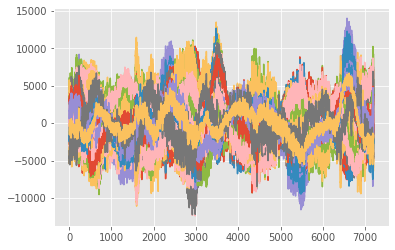

In [85]:
d, n = dataN.shape
for i in range(d):
    plt.plot(dataN[i, :])

In [86]:
fs = 120 #sampling frequency
fmin = 2 # 2Hz - 45Hz signal range, filter for this with hbp
fmax = 45
hbp = firls(101, [0, 0.005, 0.006, 0.007, 0.008, 1], desired = np.array([0, 0, 1, 1, 0, 0]))
#hbp = firls(101, np.array([0, 0.2*fmin, 0.9*fmin, fmax-2, fmax+5, 60])*2/fs,
#           desired = np.array([0, 0, 1, 1, 0, 0])) #for detrending, a bandpass
dataHPF = lfilter(hbp, 1, dataN)

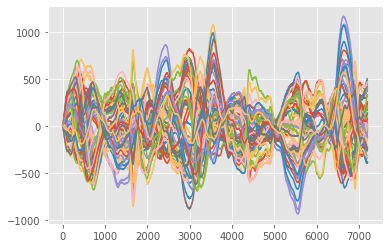

In [87]:
d, n = dataN.shape
for i in range(d):
    plt.plot(dataHPF[i, :])

## Detection on data with screening and no HPF

In [88]:
paras = edict()
paras.Lmin = 200
paras.wh = 10
paras.MaxM = 20
paras.fct = 0.5
paras.r = 6
paras.freq = 120
paras.lamb = 1e-4
paras.T = 2
paras.is_detrend = False
paras.decimateRate = None
paras.kappa = 1
paras.downRate = 20

**Best**

wh = 10

numChg = 6

{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001/0.0005,
 'nbasis': 10,
 'r': 6/8/12}

In [92]:
detRaw = TVDNDetect1(Ymat=dataN, dataType="MEG", 
                     saveDir=None, #"MEGst02", 
                     fName="MEG1",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEG1',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 6}


In [93]:
detRaw.Screening(wh=paras.wh)
detRaw()


The class calls the new reconstruction function, ReconXmatNewBspStep


In [94]:
kappas = np.linspace(1, 4, 1000)
detRaw.TuningKappa(kappas)

The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruction function, ReconXmatNewBspStep
The class calls the new reconstruc

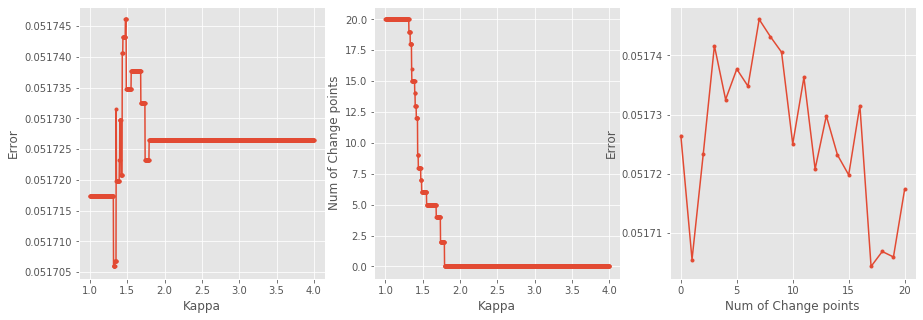

In [95]:
detRaw.PlotKappaErrCurve()

The plot indices are [50 48 19 25  4].


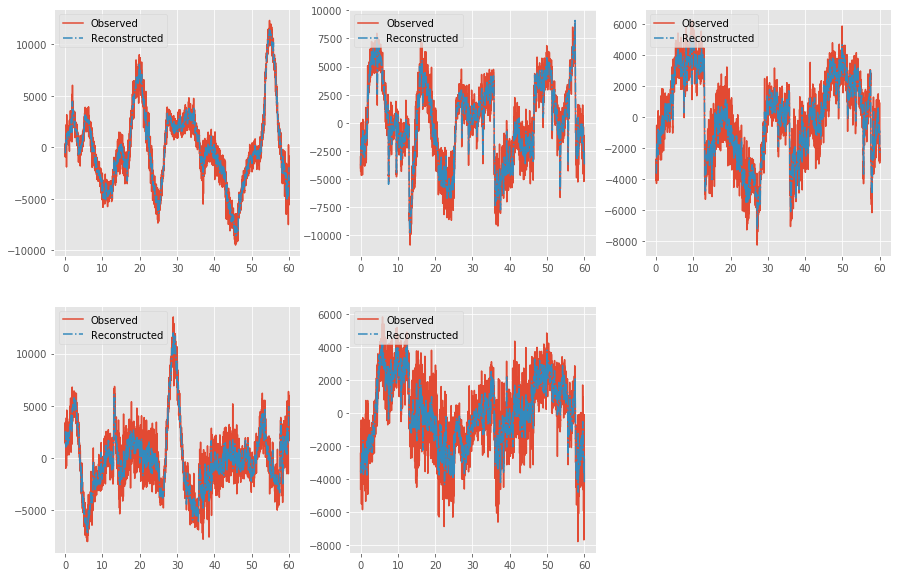

array([50, 48, 19, 25,  4])

In [96]:
detRaw.PlotRecCurve()

In [97]:
detRaw.UpdateEcpts()
print(detRaw)

+-------------+--------------------------------------------------------------------------+---------------------+------+
| Num of CPTs |                              Estiamted CPTs                              |         MSE         | Rank |
+-------------+--------------------------------------------------------------------------+---------------------+------+
|      19     | [ 244.  460.  672.  879. 1251. 1461. 1668. 1900. 2588. 3032. 3233. 3486. | 0.05170593179901576 |  6   |
|             |                3912. 4357. 5530. 5866. 6185. 6400. 6986.]                |                     |      |
+-------------+--------------------------------------------------------------------------+---------------------+------+


+-------------+--------------------------------------------------------------------------+---------------------+------+
| Num of CPTs |                              Estiamted CPTs                              |         MSE         | Rank |
+-------------+--------------------------------------------------------------------------+---------------------+------+
|      19     | [ 244.  460.  672.  879. 1251. 1461. 1668. 1900. 2588. 3032. 3233. 3486. | 0.05170593179901576 |  6   |
|             |                3912. 4357. 5530. 5866. 6185. 6400. 6986.]                |                     |      |
+-------------+--------------------------------------------------------------------------+---------------------+------+


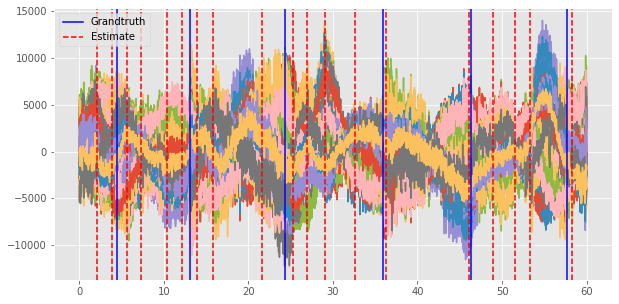

In [99]:
detRaw.UpdateEcpts()
print(detRaw)
detRaw.PlotEcpts(GT=gtSt02.cpts)

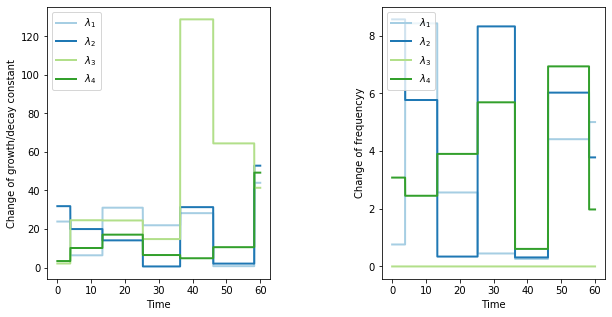

In [15]:
detRaw.PlotEigenCurve()

In [16]:
detRaw.kappas[detRaw.numchgs==6]

array([1.48648649, 1.48948949, 1.49249249, 1.4954955 , 1.4984985 ,
       1.5015015 , 1.5045045 , 1.50750751, 1.51051051, 1.51351351,
       1.51651652, 1.51951952, 1.52252252, 1.52552553, 1.52852853,
       1.53153153, 1.53453453, 1.53753754, 1.54054054, 1.54354354,
       1.54654655, 1.54954955])

## Detection on data with no  HPF and no screening

In [101]:
detRawNo = TVDNDetect1(Ymat=dataN, dataType="MEG", 
                     saveDir="MEGeye-st02-rank6", 
                     fName="MEGmin",
                     showProgress=True, 
                     MaxM=paras.MaxM,
                     Lmin=paras.Lmin, 
                     lamb=paras.lamb, 
                     kappa=paras.kappa, 
                     freq=paras.freq,
                     r=paras.r,
                     T=paras.T,
                     is_detrend=paras.is_detrend,
                     decimateRate=paras.decimateRate, 
                     downRate=paras.downRate)

The parameters for detection are:
{'Lmin': 200,
 'MaxM': 20,
 'T': 2,
 'decimateRate': None,
 'downRate': 20,
 'fName': 'MEGmin',
 'fct': 0.5,
 'freq': 120,
 'is_detrend': False,
 'kappa': 1,
 'lamb': 0.0001,
 'nbasis': 10,
 'r': 6}


In [102]:
detRawNo()

/home/huaqingj/MyResearch/TVDN/pyTVDN/TVDNclass.py:266: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)


In [103]:
kappas = np.linspace(1, 4, 1000)
detRawNo.TuningKappa(kappas)

+-------------+---------------------------------------+-------------------+------+
| Num of CPTs |             Estiamted CPTs            |        MSE        | Rank |
+-------------+---------------------------------------+-------------------+------+
|      6      | [ 466. 1600. 3030. 4367. 5512. 7000.] | 5.735169278207809 |  6   |
+-------------+---------------------------------------+-------------------+------+


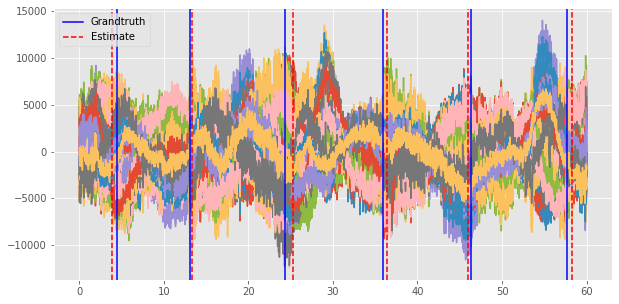

In [104]:
detRawNo.UpdateEcpts(6)
print(detRawNo)
detRawNo.PlotEcpts(GT=gtSt02.cpts, saveFigPath="../plots/MEG-eye-02-cpts.jpg")

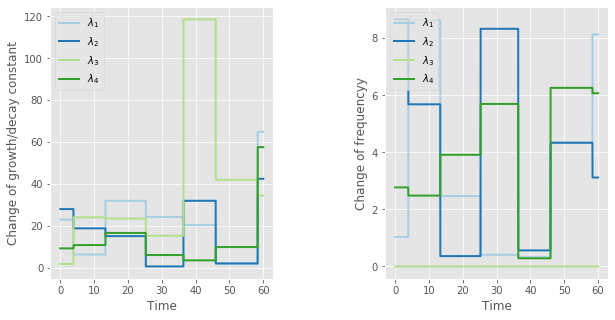

In [43]:
detRawNo.PlotEigenCurve(saveFigPath="../plots/MEG-eye-02-lam.jpg")

The plot indices are [41 58 36 29 38].


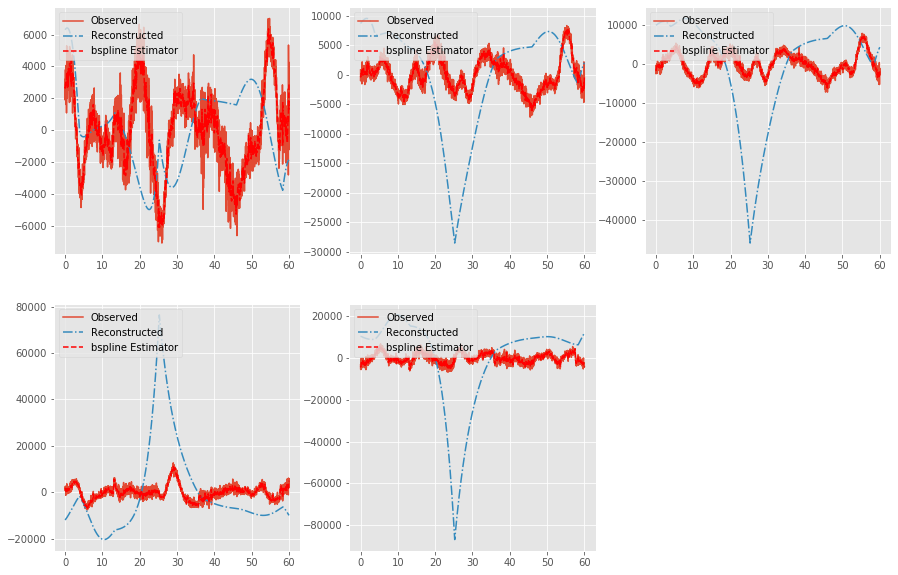

array([41, 58, 36, 29, 38])

In [108]:
detRawNo.PlotRecCurve(is_smoothCurve=1)

In [22]:
detRawNo.kappas[detRawNo.numchgs==6]

array([1.48948949, 1.49249249, 1.4954955 , 1.4984985 , 1.5015015 ,
       1.5045045 , 1.50750751, 1.51051051, 1.51351351, 1.51651652,
       1.51951952, 1.52252252, 1.52552553, 1.52852853, 1.53153153,
       1.53453453, 1.53753754, 1.54054054, 1.54354354, 1.54654655,
       1.54954955])

### Save results

In [115]:
def obtainwU(DetObj):
    eigVecs = DetObj.midRes.eigVecs[:, :DetObj.paras.r]
    kpidxs = np.concatenate([[0], DetObj.ecpts]).astype(np.int)
    eigVals = DetObj.RecResCur.LamMs[:, kpidxs]
    wU = eigVecs.dot(eigVals)
    return wU

def minmax(x):
    num = x - np.min(x)
    den = np.max(x) - np.min(x)
    return num/den

In [116]:
wUst = obtainwU(detRawNo)
wUst = np.transpose(wUst)
abswUst = np.abs(wUst)
# save to npy file
with open("MEG02_abswU_full.npy", "wb") as f:
    np.save(f, abswUst)
with open("MEG02_wU_full.npy", "wb") as f:
    np.save(f, wUst)

abswUstMM = np.zeros_like(abswUst)
for i, col in enumerate(abswUst):
    lh = minmax(col[:34])
    rh = minmax(col[34:])
    abswUstMM[i, :34] = lh
    abswUstMM[i, 34:] = rh

In [117]:
import pandas as pd

fcR = pd.read_csv('../data/brain_plot_meg/DK_dic68.csv').set_index('Unnamed: 0')
rowNames = list(fcR.index)
colNames = np.array(fcR.columns)

fcRarr = np.array(fcR)

# minmax 
fcRarrMM = np.zeros_like(fcRarr)
for i, fcRar in enumerate(fcRarr):
    lh = minmax(fcRar[:34])
    rh = minmax(fcRar[34:])
    fcRarrMM[i, :34] = lh
    fcRarrMM[i, 34:] = rh

In [118]:
from collections import OrderedDict as odict
csvD = odict()
for i, name in enumerate(colNames):
    csvD[name] = abswUstMM[:, i]

csvD = pd.DataFrame(csvD)
csvD.to_csv("wU_minmax_st02.csv")

In [123]:
import scipy.stats as ss
from collections import defaultdict as ddict
corrs = ddict(list)
for absU in abswUstMM:
    for j, name in enumerate(rowNames):
        corrs[name].append(ss.pearsonr(fcRarrMM[j, :], absU)[0])
        #corrs[name].append(ss.spearmanr(fcRarrMM[j, :], absU)[0])
    
corrsDF = pd.DataFrame(corrs)
corrsDF.to_csv("corrs_st02.csv")

In [124]:
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.210025,0.107276,-0.247228,-0.131016,-0.111780,-0.077050,0.512698
1,-0.241851,0.107868,0.028050,-0.177083,0.288255,0.268074,-0.115419
2,0.338231,-0.202339,-0.075398,0.382806,-0.368176,-0.303210,0.031923
3,0.247768,0.064673,0.115631,0.052632,-0.135479,-0.030580,-0.190268
4,0.146349,0.005005,-0.043878,0.162883,0.140925,-0.038782,-0.336717
5,0.193645,-0.044007,-0.067590,0.163647,-0.101192,0.026348,-0.178447
6,0.095520,-0.171088,-0.093179,0.172298,-0.426890,-0.282722,0.461282


In [122]:
corrsDF

,Default,Dorsal_Attention,Frontoparietal,Limbic,Somatomotor,Ventral_Attention,Visual
0,-0.219168,-0.011426,-0.255073,-0.120701,-0.005432,-0.202110,0.403050
1,-0.218476,0.198583,0.050977,-0.261575,0.343593,0.336038,-0.117113
2,0.259056,-0.303857,-0.045238,0.325770,-0.460266,-0.343501,0.098143
3,0.231143,0.111300,0.121367,0.142560,-0.185652,-0.048266,-0.140080
4,0.119462,0.066461,0.019314,0.026158,0.074797,-0.016832,-0.313072
5,0.258816,-0.197589,0.043398,0.300909,-0.074654,-0.032894,-0.041699
6,0.029356,-0.249708,-0.099857,0.108367,-0.518823,-0.422999,0.356107
